## Check observables given a results file from a `TRSL` simulation

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [92]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [93]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

In [94]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150818_1920_3599s.p"

Make file readable by `ipython` in case it was created by `pypy`:

In [95]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [96]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [97]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [98]:
size = 4
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

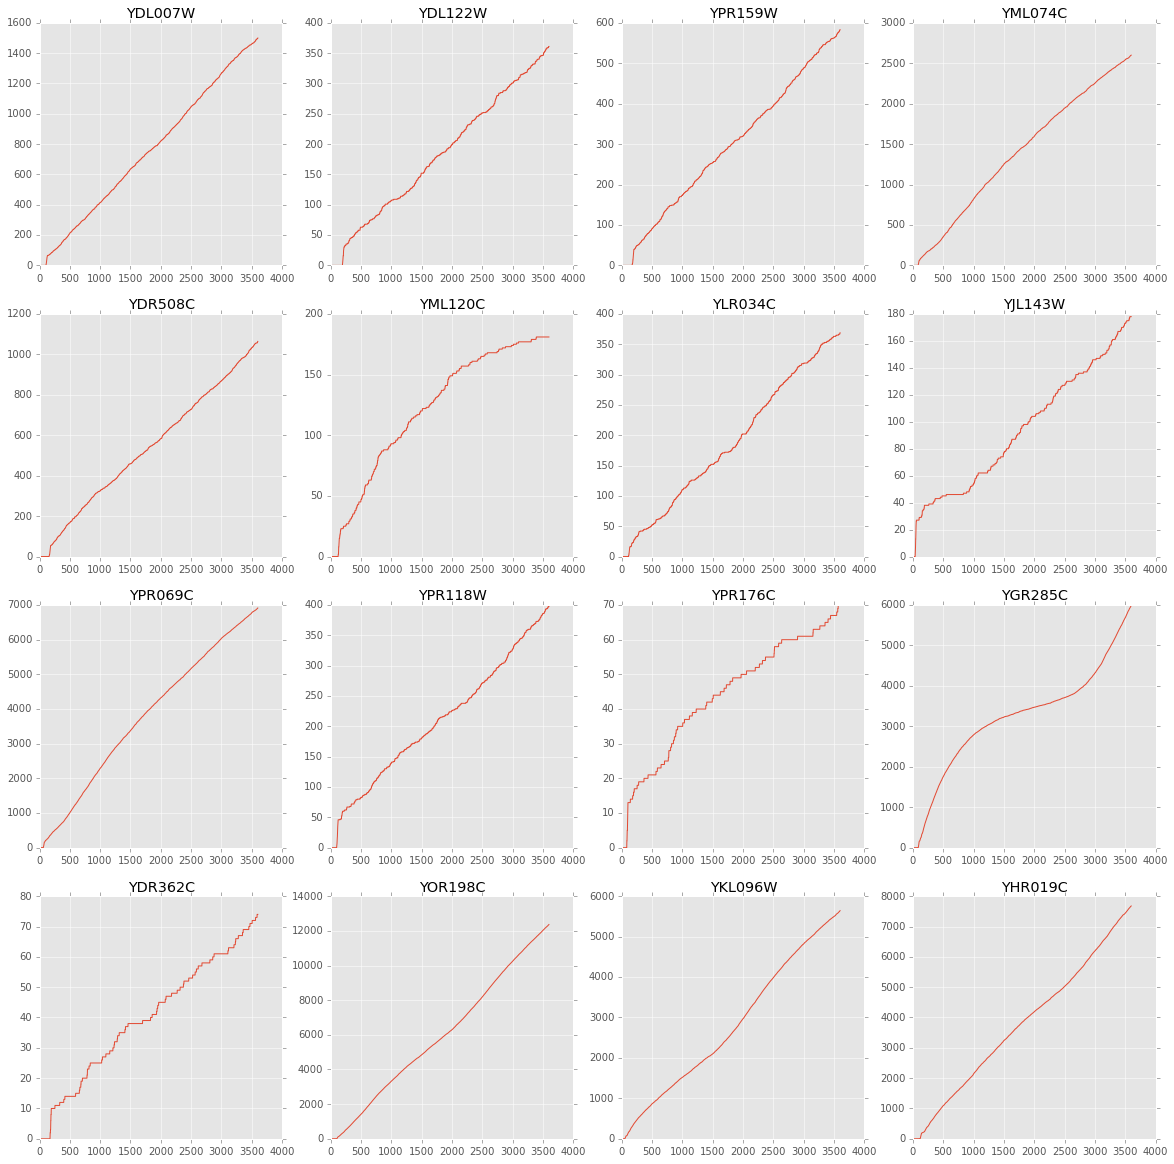

In [99]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        ax[i, j].plot(results['timerange'], results['timecourses'][protnames_plot[i][j]])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation (TODO: start and stop should be automatic):

In [100]:
start, stop = 599, 3599  # to exclude the "burn in" phase
prot_speeds = {}

for prot in protnames:
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * stop - start)
    if prot_speeds[prot] > 50: 
        print prot, prot_speeds[prot]

YKL060C 78.9
YAL038W 113.273333333
YCR012W 62.2076666667
YOL086C 50.837
YLR044C 255.591666667
YOL040C 52.4876666667


In [101]:
pd.Series(prot_speeds.values()).describe()

count    2496.000000
mean        1.035836
std         6.943294
min         0.000667
25%         0.024667
50%         0.070000
75%         0.243000
max       255.591667
dtype: float64

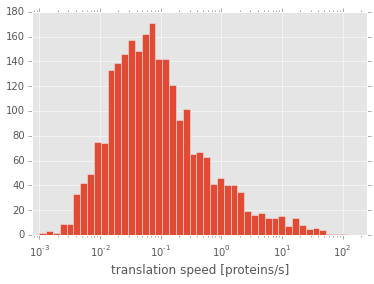

In [102]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

In [103]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [104]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [105]:
pd.Series(peptide_speeds.values()).describe()

count      2496.000000
mean        377.096605
std        3414.163554
min           0.340000
25%           9.370333
50%          25.617833
75%          87.378250
max      144153.700000
dtype: float64

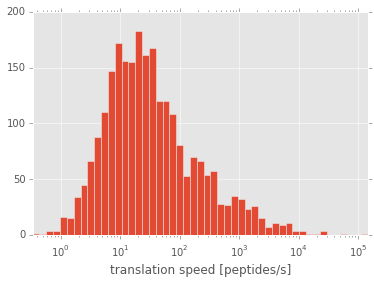

In [106]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [107]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
print len(init_rates_plotkin)

2569


In [108]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())

4839
60000


In [109]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin']

In [110]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')

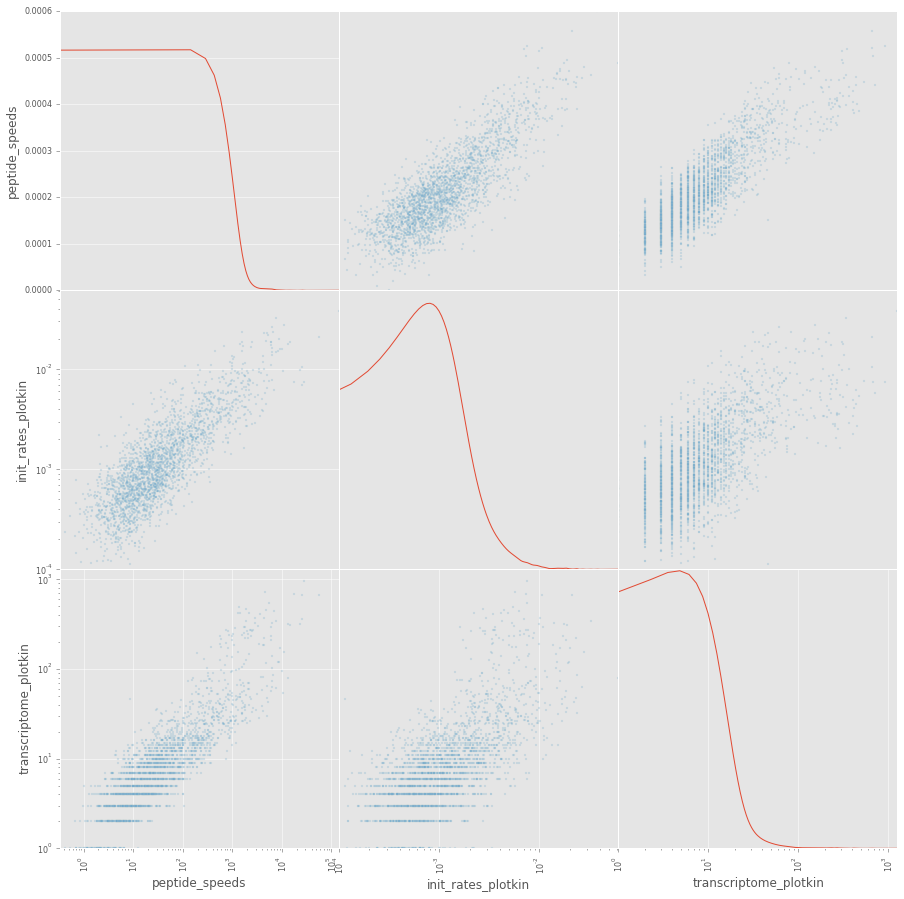

In [111]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')         

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs:

In [112]:
filepath = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150825_1823_3599s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [113]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(filepath))

TODO: explain why the following is smaller than 20000

In [115]:
len(results['transcriptome'])

16724

In [116]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [117]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

In [118]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [119]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [120]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [121]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [122]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic_toc']

In [123]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [124]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [125]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [126]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'orf_length']

In [127]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

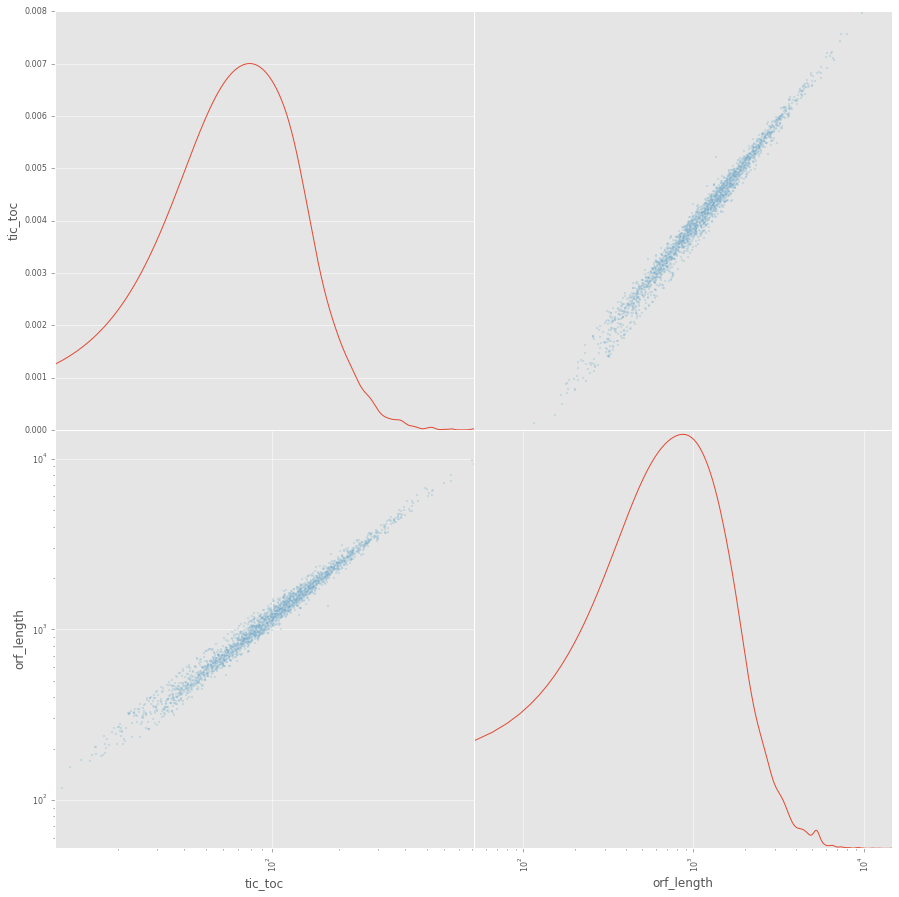

In [128]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')            

In [131]:
ribo_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [132]:
pd.Series(ribo_speed_dict.values()).describe()

count    2415.000000
mean        0.084858
std         0.007183
min         0.065803
25%         0.080472
50%         0.084706
75%         0.088999
max         0.131732
dtype: float64

(array([   5.,   11.,   12.,   21.,   17.,   25.,   24.,   43.,   30.,
          48.,   51.,   65.,   84.,   93.,  119.,  133.,  153.,  153.,
         138.,  145.,  137.,  163.,  118.,   86.,   97.,   69.,   69.,
          70.,   50.,   40.,   29.,   23.,   18.,   14.,   17.,    6.,
           4.,    3.,    9.,    6.,    2.,    5.,    4.,    3.,    0.,
           0.,    0.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0.06580341,  0.06680341,  0.06780341,  0.06880341,  0.06980341,
         0.07080341,  0.07180341,  0.07280341,  0.07380341,  0.07480341,
         0.07580341,  0.07680341,  0.07780341,  0.07880341,  0.07980341,
         0.08080341,  0.08180341,  0.08280341,  0.08380341,  0.08480341,
         0.08580341,  0.08680341,  0.08780341,  0.08880341,  0.08980341,
         0.09080341,  0.09180341,  0.09280341,  0.09380341,  0.09480341,
         0.09580341,  0.09680341,  0.0978

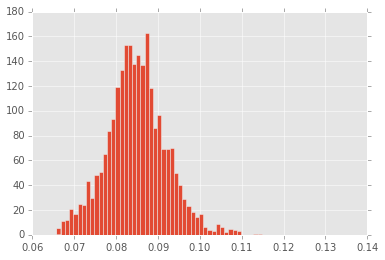

In [138]:
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.001))


Add title: seconds per nucleotide - recalculate codons per second